<p style="font-family: helvetica,arial,sans-serif; font-size:2.0em;color:white; background-color: black;">&emsp;<b>EDA: Compare Pedestrian Traffic Day and Night</b></p>
    
<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:black; background-color: #DDDDDD; text-align:justify">&emsp;<b>Authored by: </b> Barkha Javed</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black; text-align:right"> <b>Duration:</b> 45 mins&emsp;</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:black; background-color: #DDDDDD; text-align:justify">&emsp;<b>Level: </b>Beginner&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<b>Pre-requisite Skills:</b>Python</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>Scenario</b>

# Business & Activity 
As a small business owner, I want to understand how covid affected foot traffic, and how long it might take to return to normal. I'd also like deeper insights into how different activities can impact pedestrian traffic.

 Factors impacting traffic include those listed below, we will be examining some of these in depth:
- Seasonality through temperature, severe weather events,  daylight savings, public holidays such as Christmas, school holidays, 
- Time of day, day of week
- Major events such as the AFL, concerts and exhibitions
- Proximity to public transport: Trains / Buses / Trams
- Number of local residences
- Number of people travelling into the CBD
- Covid cases and status
- Other venues in proximity - schools, universities, parks, retail outlets, restaurants, bars, clubs, cinemas

This exploratory data analysis looks at <b><i>Time of day, day of week impact on foot traffic</i></b>.

## Data Preparation and setup

In [1]:
# pip -q is to give less output
!pip -q install sodapy
!pip -q install seaborn
!pip -q install pandas
!pip -q install matplotlib
!pip -q install numpy
!pip -q install nbconvert
!pip -q install keyboard
!pip -q install sklearn

In [2]:
#load libraries
import pandas as pd
import numpy as np
import requests
import io
import keyboard
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sodapy import Socrata

import warnings
warnings.filterwarnings('ignore')

### Data Acquisition Pedestrian Sensor Locations

In [3]:
#Location data
client = Socrata('data.melbourne.vic.gov.au', '9UAGAvkem9fqXDhBLElapjazL', None)
sensor_data_id = "h57g-5234"
results = client.get(sensor_data_id)
sensor_location = pd.DataFrame.from_records(results)
#sensor_location.head(5)

sensor_location[['latitude', 'longitude']] = sensor_location[['latitude', 'longitude']].astype(float)
sensor_location = sensor_location.drop('location',axis=1)

#View sensor data
sensor_location.info()
sensor_location.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sensor_id           91 non-null     object 
 1   sensor_description  91 non-null     object 
 2   sensor_name         91 non-null     object 
 3   installation_date   91 non-null     object 
 4   status              91 non-null     object 
 5   note                10 non-null     object 
 6   latitude            91 non-null     float64
 7   longitude           91 non-null     float64
 8   direction_1         78 non-null     object 
 9   direction_2         78 non-null     object 
dtypes: float64(2), object(8)
memory usage: 7.2+ KB


,sensor_id,sensor_description,sensor_name,installation_date,status,note,latitude,longitude,direction_1,direction_2
0,16,Australia on Collins,Col270_T,2009-03-30T00:00:00.000,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.965210,NaN,NaN
1,50,Faraday St-Lygon St (West),Lyg309_T,2017-11-30T00:00:00.000,A,NaN,-37.798082,144.967210,South,North
2,73,Bourke St - Spencer St (South),Bou655_T,2020-10-02T00:00:00.000,I,NaN,-37.816957,144.954154,East,West
3,66,State Library - New,QVN_T,2020-04-06T00:00:00.000,A,NaN,-37.810578,144.964443,South,North
4,59,Building 80 RMIT,RMIT_T,2019-02-13T00:00:00.000,A,NaN,-37.808256,144.963049,South,North


### Data Acquisition Pedestrian Traffic

In [4]:
##Pedestrian foot count data 
sensor_data_id = "b2ak-trbp"

##Uncomment lines below to open data source, download sensor data, and store it as a csv locally.
results = client.get(sensor_data_id, limit=7000000)
ds_traffic = pd.DataFrame.from_records(results)
ds_traffic.to_csv('sensor_traffic.csv', index=False)

sensor_traffic = pd.read_csv('sensor_traffic.csv')
sensor_traffic.info()

print(f'\nThe shape of dataset is {sensor_traffic.shape}. \n')
print('Below are the first few rows of this dataset: ')
sensor_traffic.head(10)

#convert data types for merge
sensor_traffic['sensor_id']=sensor_traffic['sensor_id'].astype(int)
sensor_location['sensor_id']=sensor_location['sensor_id'].astype(int)

sensor_ds = pd.merge(sensor_traffic, sensor_location, on='sensor_id')
sensor_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463670 entries, 0 to 4463669
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             int64 
 1   date_time      object
 2   year           int64 
 3   month          object
 4   mdate          int64 
 5   day            object
 6   time           int64 
 7   sensor_id      int64 
 8   sensor_name    object
 9   hourly_counts  int64 
dtypes: int64(6), object(4)
memory usage: 340.6+ MB

The shape of dataset is (4463670, 10). 

Below are the first few rows of this dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463670 entries, 0 to 4463669
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             int64 
 1   date_time      object
 2   year           int64 
 3   month          object
 4   mdate          int64 
 5   day            object
 6   time           int64 
 7   sensor_id      int32 
 8   sensor_name    object
 9   hourly_

In [5]:
#Add date column
sensor_traffic['date'] = pd.to_datetime(sensor_traffic.date_time).dt.date

#Add day of week column
sensor_traffic['dow'] = pd.to_datetime(sensor_traffic.date_time).dt.day_of_week

sensor_traffic.head(10)

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,date,dow
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,Flinders St-Spark La,300,2019-11-01,4
1,2887629,2019-11-01T17:00:00.000,2019,November,1,Friday,17,39,Alfred Place,604,2019-11-01,4
2,2887630,2019-11-01T17:00:00.000,2019,November,1,Friday,17,37,Lygon St (East),216,2019-11-01,4
3,2887631,2019-11-01T17:00:00.000,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627,2019-11-01,4
4,2887632,2019-11-01T17:00:00.000,2019,November,1,Friday,17,36,Queen St (West),774,2019-11-01,4
5,2887633,2019-11-01T17:00:00.000,2019,November,1,Friday,17,29,St Kilda Rd-Alexandra Gardens,644,2019-11-01,4
6,2887634,2019-11-01T17:00:00.000,2019,November,1,Friday,17,42,Grattan St-Swanston St (West),453,2019-11-01,4
7,2887635,2019-11-01T17:00:00.000,2019,November,1,Friday,17,43,Monash Rd-Swanston St (West),387,2019-11-01,4
8,2887636,2019-11-01T17:00:00.000,2019,November,1,Friday,17,44,Tin Alley-Swanston St (West),27,2019-11-01,4
9,2887637,2019-11-01T17:00:00.000,2019,November,1,Friday,17,35,Southbank,2691,2019-11-01,4


In [6]:
# Mesh pedestrian sensor location and foot traffic datasets

#convert sensor_id to integer
sensor_traffic['sensor_id']=sensor_traffic['sensor_id'].astype(int)
sensor_location['sensor_id']=sensor_location['sensor_id'].astype(int)

sensor_ds = pd.merge(sensor_traffic, sensor_location, on='sensor_id')

#Add column
sensor_ds['installation_dt'] = pd.to_datetime(sensor_ds.installation_date).dt.date

#Simply using the year to differentiate all the years prior to 2020 as before Covid, and post 2019 Covid traffic to now
sensor_ds['pre2020_hourly_counts'] = np.where(sensor_ds['year']<=2019,sensor_ds['hourly_counts'] , 0)
sensor_ds['post2019_hourly_counts'] = np.where(sensor_ds['year']>2019,sensor_ds['hourly_counts'] , 0)

#Add column for day (5am to 5pm) or night (6pm to 4am) traffic
sensor_ds['day_counts']   = np.where(((sensor_ds['time']>4)  & (sensor_ds['time']<18)),sensor_ds['hourly_counts'] , 0)
sensor_ds['night_counts'] = np.where(sensor_ds['day_counts']==0,sensor_ds['hourly_counts'], 0)

#Drop column
sensor_ds = sensor_ds.drop(['installation_date','status','note','sensor_name_x'],axis=1)

#sensor_ds.info()
sensor_ds.describe()

,id,year,mdate,time,sensor_id,hourly_counts,dow,latitude,longitude,pre2020_hourly_counts,post2019_hourly_counts,day_counts,night_counts
count,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06
mean,2.232320e+06,2.017230e+03,1.574741e+01,1.146917e+01,2.700226e+01,4.951352e+02,2.999995e+00,-3.781345e+01,1.449621e+02,4.074119e+02,8.772332e+01,3.594659e+02,1.356693e+02
std,1.289316e+06,3.551188e+00,8.800020e+00,6.938594e+00,1.951539e+01,7.509822e+02,2.000015e+00,6.187582e-03,8.531568e-03,7.443612e+02,2.852713e+02,7.131327e+02,3.910920e+02
min,1.000000e+00,2.009000e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-3.782402e+01,1.449297e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.115918e+06,2.015000e+03,8.000000e+00,5.000000e+00,1.100000e+01,4.300000e+01,1.000000e+00,-3.781874e+01,1.449587e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.231836e+06,2.018000e+03,1.600000e+01,1.100000e+01,2.300000e+01,1.780000e+02,3.000000e+00,-3.781381e+01,1.449651e+02,6.200000e+01,0.000000e+00,2.400000e+01,0.000000e+00
75%,3.347753e+06,2.020000e+03,2.300000e+01,1.700000e+01,4.100000e+01,6.050000e+02,5.000000e+00,-3.781102e+01,1.449669e+02,4.530000e+02,2.400000e+01,3.520000e+02,5.900000e+01
max,4.469141e+06,2.022000e+03,3.100000e+01,2.300000e+01,8.700000e+01,1.597900e+04,6.000000e+00,-3.779432e+01,1.449747e+02,1.597900e+04,1.443700e+04,1.161200e+04,1.597900e+04


In [7]:
sensor_ds.head(10)

,id,date_time,year,month,mdate,day,time,sensor_id,hourly_counts,date,...,sensor_name_y,latitude,longitude,direction_1,direction_2,installation_dt,pre2020_hourly_counts,post2019_hourly_counts,day_counts,night_counts
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,300,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,300,0,300,0
1,2887683,2019-11-01T18:00:00.000,2019,November,1,Friday,18,34,240,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,240,0,0,240
2,2887738,2019-11-01T19:00:00.000,2019,November,1,Friday,19,34,158,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,158,0,0,158
3,2887793,2019-11-01T20:00:00.000,2019,November,1,Friday,20,34,118,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,118,0,0,118
4,2887848,2019-11-01T21:00:00.000,2019,November,1,Friday,21,34,131,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,131,0,0,131
5,2887903,2019-11-01T22:00:00.000,2019,November,1,Friday,22,34,218,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,218,0,0,218
6,2887958,2019-11-01T23:00:00.000,2019,November,1,Friday,23,34,154,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,154,0,0,154
7,2888013,2019-11-02T00:00:00.000,2019,November,2,Saturday,0,34,21,2019-11-02,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,21,0,0,21
8,2888068,2019-11-02T01:00:00.000,2019,November,2,Saturday,1,34,21,2019-11-02,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,21,0,0,21
9,2888123,2019-11-02T02:00:00.000,2019,November,2,Saturday,2,34,4,2019-11-02,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,4,0,0,4


### Seperate day and night data sets

In [8]:
flag_value=0
df_day=sensor_ds.query("day_counts > @flag_value")
print('Day info \n',df_day.info(),'\n')

df_night=sensor_ds.query("day_counts == @flag_value")
print('Night info \n',df_night.info(),'\n')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2402520 entries, 0 to 4463663
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      int64  
 1   date_time               object 
 2   year                    int64  
 3   month                   object 
 4   mdate                   int64  
 5   day                     object 
 6   time                    int64  
 7   sensor_id               int32  
 8   hourly_counts           int64  
 9   date                    object 
 10  dow                     int64  
 11  sensor_description      object 
 12  sensor_name_y           object 
 13  latitude                float64
 14  longitude               float64
 15  direction_1             object 
 16  direction_2             object 
 17  installation_dt         object 
 18  pre2020_hourly_counts   int64  
 19  post2019_hourly_counts  int64  
 20  day_counts              int64  
 21  night_counts            int64  

## Examine Pedestrian Traffic Hourly Counts

In [9]:
#examine hourly foot traffic, sort and examine just the hourly counts, to see distribution and outliers
ds = pd.DataFrame(sensor_ds["hourly_counts"])
ds.info()
df = ds.sort_values(by=['hourly_counts'], ascending=False)
rs = df.value_counts()
print('\n Hourly Counts in descending order', rs, '\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4463670 entries, 0 to 4463669
Data columns (total 1 columns):
 #   Column         Dtype
---  ------         -----
 0   hourly_counts  int64
dtypes: int64(1)
memory usage: 68.1 MB

 Hourly Counts in descending order hourly_counts
0                75117
1                50592
2                50422
3                46444
4                44498
                 ...  
6117                 1
6118                 1
6119                 1
6124                 1
15979                1
Length: 6410, dtype: int64 



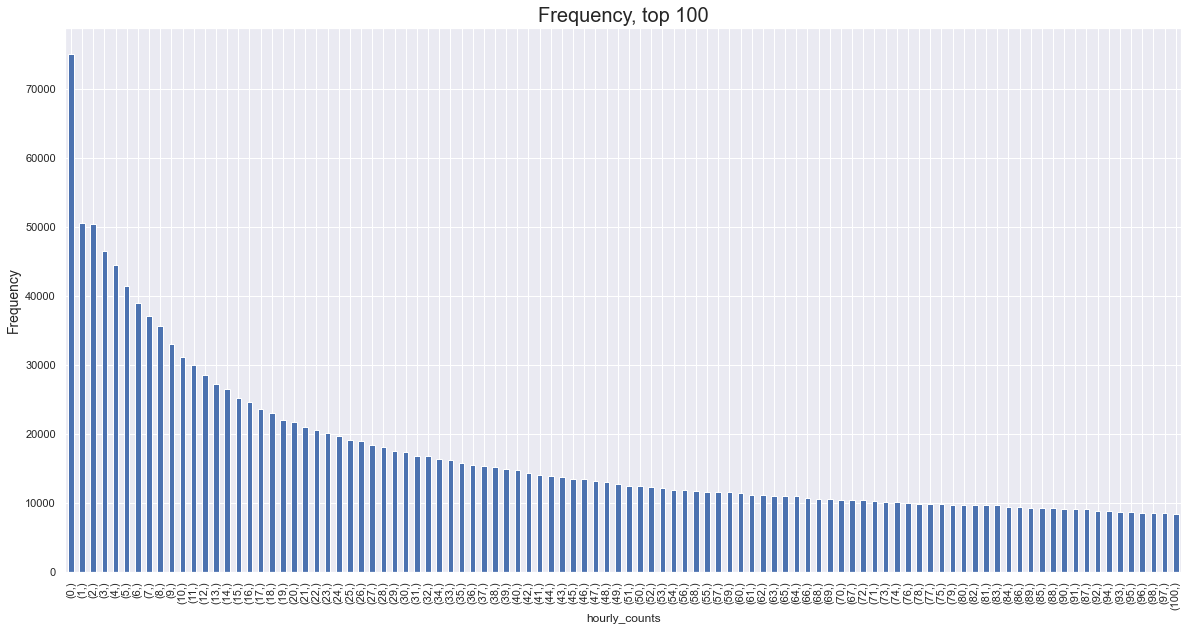

In [10]:
axs = rs[:100].plot.bar(figsize=(20, 10), rot = 90)
axs.set_title('Frequency, top 100', size=20)
axs.set_ylabel('Frequency', size=14)
plt.show()


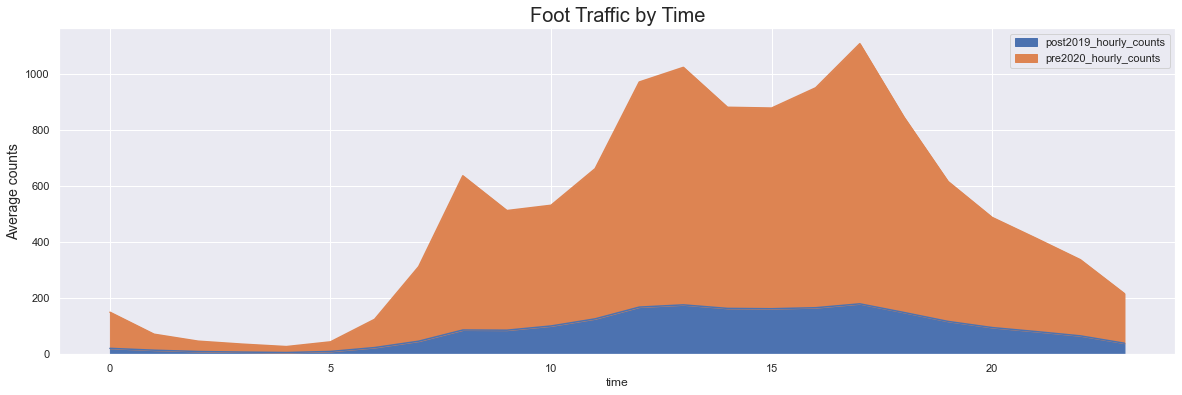

In [11]:
#examine pre Covid and post 2019 foot traffic
ds = pd.DataFrame(sensor_ds.groupby(["time"])["post2019_hourly_counts","pre2020_hourly_counts"].mean())
df = ds.sort_values(by=['time'])
axs = df.plot.area(figsize=(20, 6))
axs.set_title('Foot Traffic by Time', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()


## Examine Pedestrian Traffic by Weekday 

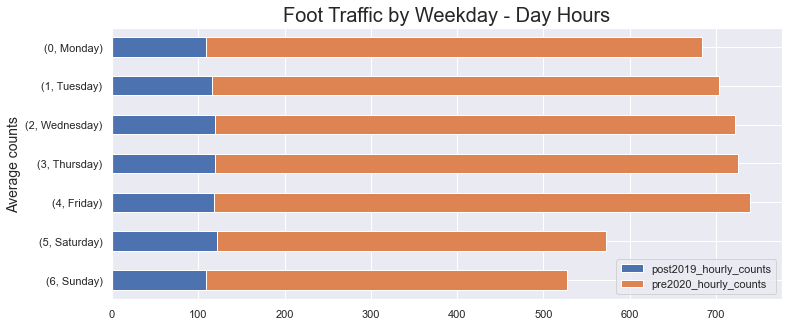

               post2019_hourly_counts  pre2020_hourly_counts
dow day                                                     
0   Monday                 108.672732             575.217959
1   Tuesday                115.421740             588.282018
2   Wednesday              119.291492             602.673719
3   Thursday               119.240018             606.327427
4   Friday                 118.037838             621.057157
5   Saturday               121.193445             451.183935
6   Sunday                 109.023656             418.899238


In [12]:
#distribution by traffic, by day - Covid impact on day
df_day['pre2020_hourly_counts'] = np.where(df_day['year']<=2019,df_day['hourly_counts'] , 0)
pivot = pd.pivot_table(df_day, values=["pre2020_hourly_counts","post2019_hourly_counts"], index=['dow','day'], aggfunc=np.mean)
rs = pivot.sort_values(by='dow', ascending = False)
axs =rs.plot.barh(figsize=(12, 5), stacked=True);

axs.set_title('Foot Traffic by Weekday - Day Hours', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

print(pivot)


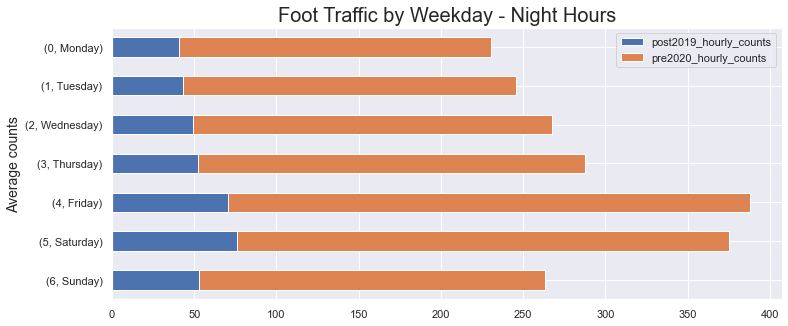

               post2019_hourly_counts  pre2020_hourly_counts
dow day                                                     
0   Monday                  40.560096             189.703862
1   Tuesday                 43.002026             202.723255
2   Wednesday               49.214528             218.310429
3   Thursday                52.259859             235.018921
4   Friday                  70.742168             316.916047
5   Saturday                76.157817             298.691270
6   Sunday                  52.664457             210.678895


In [13]:
#distribution by traffic, by night - Covid impact on night
df_night['pre2020_hourly_counts'] = np.where(df_night['year']<=2019,df_night['night_counts'] , 0)
pivot = pd.pivot_table(df_night, values=["pre2020_hourly_counts","post2019_hourly_counts"], index=['dow','day'], aggfunc=np.mean)
rs = pivot.sort_values(by='dow', ascending = False)
axs =rs.plot.barh(figsize=(12, 5), stacked=True);

axs.set_title('Foot Traffic by Weekday - Night Hours', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

print(pivot)

## Examine Pedestrian Traffic by Day and Night

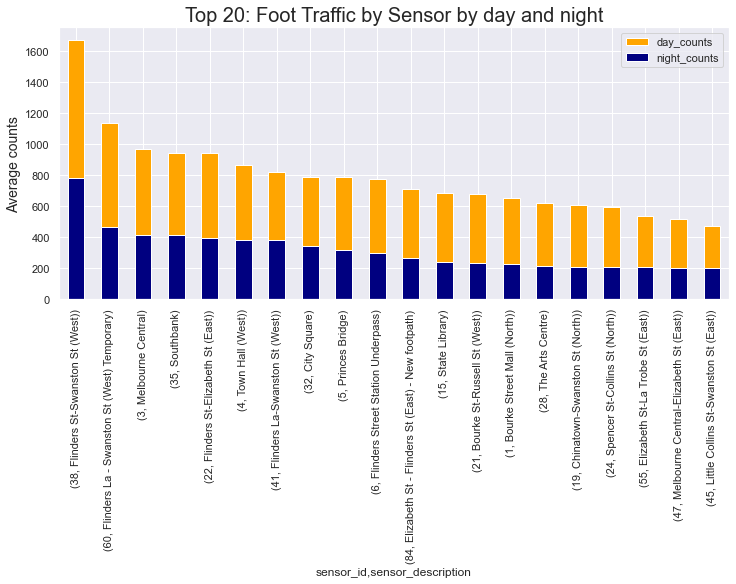

In [14]:
#distribution by traffic, by day
pivot = pd.pivot_table(sensor_ds, values='day_counts', index=['sensor_id','sensor_description'], aggfunc=np.mean)
pivot_ds = pivot['day_counts'].nlargest(n=20)
pivot_ds.plot.bar(figsize=(12, 5), color='orange', legend=True);

#by night
pivot = pd.pivot_table(sensor_ds, values='night_counts', index=['sensor_id','sensor_description'], aggfunc=np.mean)
pivot_ds = pivot['night_counts'].nlargest(n=20)
axs = pivot_ds.plot.bar(figsize=(12, 5), color='navy', legend=True);

axs.set_title('Top 20: Foot Traffic by Sensor by day and night', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

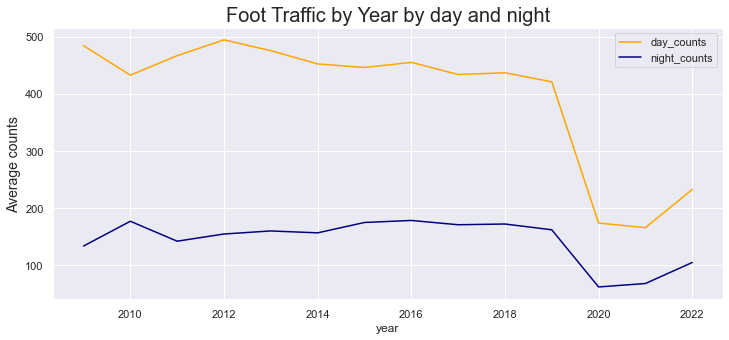

In [15]:
#distribution by traffic, by day
pivot = pd.DataFrame(pd.pivot_table(sensor_ds, values=['day_counts','night_counts'], index=['year'], aggfunc=np.mean))
rs = pivot.sort_values(by='year', ascending = False)
axs = rs.plot.line(figsize=(12, 5), color=['orange','navy'], legend=True);

axs.set_title('Foot Traffic by Year by day and night', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

## Clustering Analysis - Approach 1

We will cluster on just the pedestrain data set which many dimensions, but just has one measure - hourly counts.

### Examine: All Hours

In [16]:
#identify class and features
class_list = ["sensor_id"]
features_list = ["hourly_counts"]

#separate class and features - all hours
df_class = pd.DataFrame(sensor_ds[class_list])
df_features_all = pd.DataFrame(sensor_ds[features_list])

#examine data
df_features_all.describe()

,hourly_counts
count,4.463670e+06
mean,4.951352e+02
std,7.509822e+02
min,0.000000e+00
25%,4.300000e+01
50%,1.780000e+02
75%,6.050000e+02
max,1.597900e+04


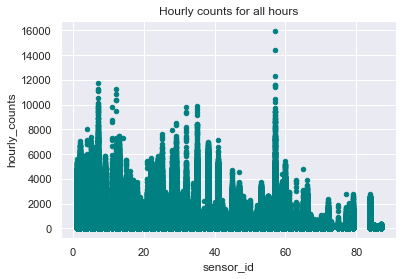

In [17]:
#what does the data look like
sensor_ds.plot(kind="scatter",x="sensor_id",y="hourly_counts", color='Teal')
plt.title('Hourly counts for all hours')
plt.show()

### Examine: Day Hours

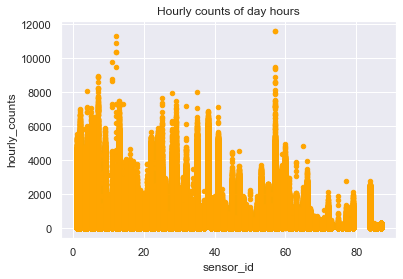

In [18]:
features_list = ["latitude", "longitude","day_counts"]
#separate class and features - day hours
df_class = pd.DataFrame(df_day[class_list])
df_features = pd.DataFrame(df_day[features_list])

#examine data
df_features.describe()#separate class and features - day hours only 

#plot classses
df_day.plot(kind="scatter",x="sensor_id",y="hourly_counts", color='Orange')
plt.title('Hourly counts of day hours')
plt.show()

### Examine: Night Hours

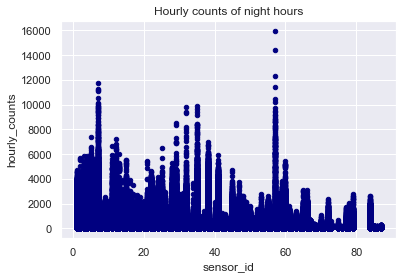

In [19]:
features_list = ["mdate", "dow","night_counts"]

#separate class and features - night hours
df_class = pd.DataFrame(df_night[class_list])
df_features_night = pd.DataFrame(df_night[features_list])

#examine data
df_features_night.describe()#separate class and features - night hours only 

#separate class and features - night hours only 
df_night.plot(kind="scatter",x="sensor_id",y="hourly_counts", color='Navy')
plt.title('Hourly counts of night hours')
plt.show()


Day, night and all hours look similar in terms of traffic by sensor, will further examine day hours

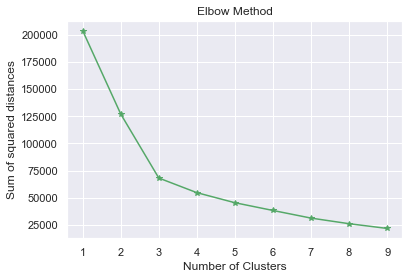

In [20]:
#scale the features, excluding class
mms = MinMaxScaler()
mms.fit(df_features) #day hours
data_transformed = mms.transform(df_features)

#data_transformed

# for each k value calculate sum of squared distances to the nearest cluster centre
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
#plot results
plt.plot(K, Sum_of_squared_distances, 'g*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

In [54]:
print("Using the elbow method on the features dataset, the optimal number of clusters is 3")

# use complete loaded features data set
# define centroids

df = df_features
kmeans = KMeans(n_clusters=3).fit(df)
centroids = kmeans.cluster_centers_
print("centroids \n", centroids,"\n")


Using the elbow method on the features dataset, the optimal number of clusters is 3
centroids 
 [[-3.78123591e+01  1.44962217e+02  4.43662724e+04  2.25841219e+02]
 [-3.78118930e+01  1.44960465e+02  2.18810246e+06  3.51567704e+02]
 [-3.78121986e+01  1.44960850e+02  1.22517645e+06  3.53957972e+02]] 



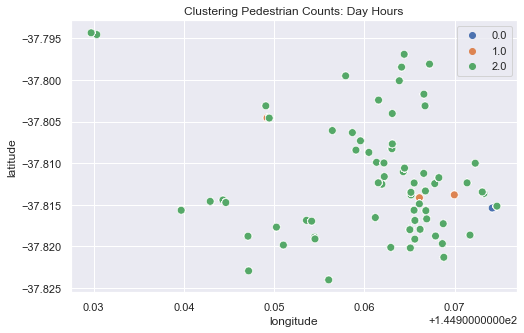

In [62]:
cluster_legend = kmeans.labels_.astype(float)
plt.figure(figsize = (8,5))
sns.scatterplot(x_axis, y_axis, hue=cluster_legend, c=cluster_legend, palette='deep', s=60)
plt.title('Clustering Pedestrian Counts: Day Hours')
plt.show()

In [ ]:
#visualise data
x_axis = df['longitude']
y_axis = df['longitude']
cluster_legend = kmeans.labels_.astype(float)
plt.figure(figsize = (8,5))
sns.scatterplot(x_axis, y_axis, hue=cluster_legend, c=cluster_legend, palette='deep', s=60)
plt.title('Clustering Pedestrian Counts: Day Hours')
plt.show()

## Clustering Analysis - Approach 2

We will add Covid cases to the pedestrain dataset, so that can evaluate more than one measure.

In [28]:
#download covid dataset
url = "https://raw.githubusercontent.com/M3IT/COVID-19_Data/master/Data/COVID_Data_Hub_State.csv"
download = requests.get(url).content
df_hub= pd.read_csv(io.StringIO(download.decode('utf-8')))

In [29]:
#look at VIC data
options = ['Victoria']
  
# selecting rows based on condition
ds = df_hub[df_hub['administrative_area_level_2'].isin(options)]
ds_hub = ds[['date','confirmed','deaths','positives','people_vaccinated','people_fully_vaccinated','administrative_area_level_2']]

#log transform - may want to apply to more variables
ds_hub['confirmed_log']=np.log(np.log(ds_hub['confirmed']))

print (ds_hub.head(), '\n')
print (ds_hub.describe(), '\n')
print (ds_hub.info())
print("\nTotal number of missing values is","{:,d}".format(ds_hub.isnull().values.sum()))
print("\nColumn-wise distribution of null values\n",ds_hub.isnull().sum())

          date  confirmed  deaths  positives  people_vaccinated  \
6   2020-01-25          1       0        0.0                  0   
14  2020-01-26          1       0        0.0                  0   
22  2020-01-27          1       0        0.0                  0   
30  2020-01-28          1       0        0.0                  0   
38  2020-01-29          3       0        0.0                  0   

    people_fully_vaccinated administrative_area_level_2  confirmed_log  
6                         0                    Victoria           -inf  
14                        0                    Victoria           -inf  
22                        0                    Victoria           -inf  
30                        0                    Victoria           -inf  
38                        0                    Victoria       0.094048   

          confirmed       deaths     positives  people_vaccinated  \
count  9.700000e+02   970.000000  9.700000e+02       9.700000e+02   
mean   4.650031e+05

In [30]:
#check merge column is of same data type, convert if required
ds_hub['date'] = pd.to_datetime(ds_hub['date'], infer_datetime_format=True)
sensor_ds['date'] = pd.to_datetime(sensor_ds['date'], infer_datetime_format=True)

# Mesh Covid and foot traffic datasets
sensor_covid = pd.merge(sensor_ds, ds_hub, on='date')

#drop columns
ds_hub.info()
sensor_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 6 to 7758
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         970 non-null    datetime64[ns]
 1   confirmed                    970 non-null    int64         
 2   deaths                       970 non-null    int64         
 3   positives                    970 non-null    float64       
 4   people_vaccinated            970 non-null    int64         
 5   people_fully_vaccinated      970 non-null    int64         
 6   administrative_area_level_2  970 non-null    object        
 7   confirmed_log                970 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 68.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4463670 entries, 0 to 4463669
Data columns (total 22 columns):
 #   Column                  Dtype         
---  -

Evaluating hourly counts and confirmed covid cases 

In [31]:
#identify class and features
use_list = ["sensor_id","latitude","longitude", "confirmed","hourly_counts"]
loc_day = pd.DataFrame(sensor_covid[use_list])
print(loc_day.head(5))

#used for associating cluster value to sensor
codes = loc_day[['sensor_id']] #class
loc_day.drop('sensor_id', axis=1, inplace=True)

#for categorical values -- if wanted to use direction
#label_encoder = LabelEncoder()
#sensor_covid['direction_1'] = label_encoder.fit_transform(sensor_covid['direction_1'])
#sensor_covid['direction_2'] = label_encoder.fit_transform(sensor_covid['direction_2'])

print('\nTransformed data for processing\n ',sensor_covid.head(5))

   sensor_id  latitude   longitude  confirmed  hourly_counts
0         34 -37.81538  144.974151          1             62
1         34 -37.81538  144.974151          1            187
2         34 -37.81538  144.974151          1             13
3         34 -37.81538  144.974151          1              8
4         34 -37.81538  144.974151          1             11

Transformed data for processing
          id                date_time  year    month  mdate       day  time  \
0  2999460  2020-01-25T00:00:00.000  2020  January     25  Saturday     0   
1  2999516  2020-01-25T01:00:00.000  2020  January     25  Saturday     1   
2  2999572  2020-01-25T02:00:00.000  2020  January     25  Saturday     2   
3  2999628  2020-01-25T03:00:00.000  2020  January     25  Saturday     3   
4  2999684  2020-01-25T04:00:00.000  2020  January     25  Saturday     4   

   sensor_id  hourly_counts       date  ...  post2019_hourly_counts  \
0         34             62 2020-01-25  ...                      

To identify how many optimal clusters to look for in the data, use the method below.

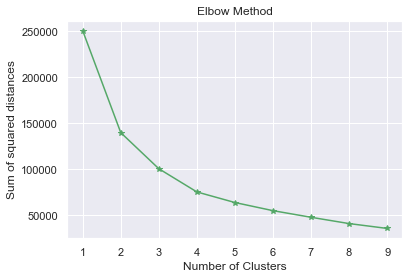

In [32]:
features_list = ["latitude","longitude", "confirmed","hourly_counts"]
df_features = pd.DataFrame(loc_day[features_list])

#scale the features
mms = MinMaxScaler()
mms.fit(df_features) #day hours
data_transformed = mms.transform(df_features)

#data_transformed

# for each k value calculate sum of squared distances to the nearest cluster centre
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
#plot results
plt.plot(K, Sum_of_squared_distances, 'g*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

Using the elbow method, could possibly use 2, 4 or 5 clusters. Will use 4 clusters.

In [33]:
# run k-means clustering, define centroids
kmeans = KMeans(n_clusters=4, random_state=0).fit(loc_day)
centroids = kmeans.cluster_centers_

codes['cluster'] = kmeans.labels_
#codes.head()

Variance explained by each component (%): 

 1 º: 99.99996777255456

 2 º: 3.2227445417813705e-05

 3 º: 1.1911432615646741e-14

 4 º: 7.380175289929683e-15
Total sum (%):  99.99999999999999
Explained variance of the first two components (latitude and longitude) (%):  99.99999999999997


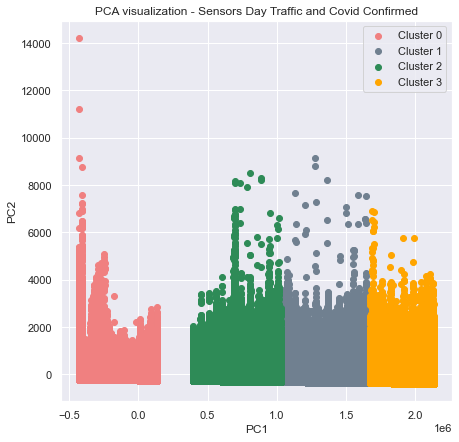

In [34]:
#Code adapted from (Carlini: 2019)
pca = PCA().fit(loc_day)
pca_types = pca.transform(loc_day)
print("Variance explained by each component (%): ")
for i in range(len(pca.explained_variance_ratio_)):
      print("\n",i+1,"º:", pca.explained_variance_ratio_[i]*100)
print("Total sum (%): ",sum(pca.explained_variance_ratio_)*100)
print("Explained variance of the first two components (latitude and longitude) (%): ",sum(pca.explained_variance_ratio_[0:2])*100)


# 4 clusters
c0 = []
c1 = []
c2 = []
c3 = []

for i in range(len(pca_types)):
    if kmeans.labels_[i] == 0:
        c0.append(pca_types[i])
    if kmeans.labels_[i] == 1:
        c1.append(pca_types[i])
    if kmeans.labels_[i] == 2:
        c2.append(pca_types[i])
    if kmeans.labels_[i] == 3:
        c3.append(pca_types[i])
        
        
c0 = np.array(c0)
c1 = np.array(c1)
c2 = np.array(c2)
c3 = np.array(c3)

plt.figure(figsize=(7,7))
plt.scatter(c0[:,0], c0[:,1], c='lightcoral', label='Cluster 0')
plt.scatter(c1[:,0], c1[:,1], c='slategrey', label='Cluster 1')
plt.scatter(c2[:,0], c2[:,1], c='seagreen', label='Cluster 2')
plt.scatter(c3[:,0], c3[:,1], c='orange', label='Cluster 3')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA visualization - Sensors Day Traffic and Covid Confirmed');

   latitude   longitude  confirmed  hourly_counts  cluster
0 -37.81538  144.974151          1             62        0
1 -37.81538  144.974151          1            187        0
2 -37.81538  144.974151          1             13        0
3 -37.81538  144.974151          1              8        0
4 -37.81538  144.974151          1             11        0


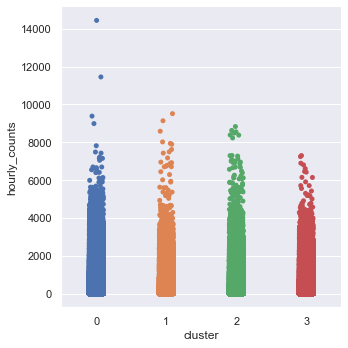

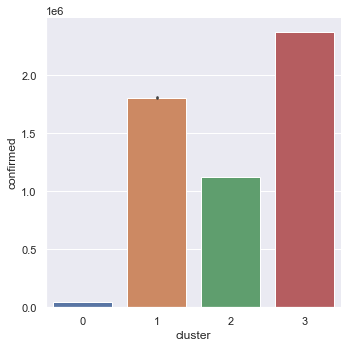

In [35]:
#Add cluster values by sensor, to the data set to see which cluster the sensor belongs to
loc_day['cluster']  = kmeans.labels_
print(loc_day.head(5))

#plot data for each measure
sns.catplot(x='cluster', y='hourly_counts', data=loc_day);
sns.catplot(x='cluster', y='confirmed', data=loc_day, kind='bar');


Overall impact seems to be minimal from confirmed cases. Looking at the the charts above cluster 3 has the most impact from confirmed cases, followed by cluster 1.

This would be interesting to investigate with more factors impacting pedestrian traffic. 

Additional work is required to try different clustering methods like DBScan, Gaussian or Spectral clustering, and compare  different distance measures like Manhattan, Cirty Block, Euclidean.


<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>References</b>

City of Melbourne Open Data Team, 2014 - 2021,'Pedestrian Counting System - Monthly (counts per hour)', City of Melbourne, date retrieved 11 Aug 2022, <https://dev.socrata.com/foundry/data.melbourne.vic.gov.au/b2ak-trbp>

City of Melbourne Open Data Team, 2014 - 2021,'Pedestrian Counting System - Sensor Locations', City of Melbourne, date retrieved 26 Aug 2022, <https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234>

Carlini L 2019, 'Clustering and Visualisation using Folium Maps', Kaggle, retrieved 23 Sep 2022 https://www.kaggle.com/code/lucaspcarlini/clustering-and-visualisation-using-folium-maps/notebook#Folium-Maps-Visualisation-by-Number-of-Occurences-and-Clustering
    

In [64]:
#save notebook, required so that step to convert to html, writes latest results to file
# may need to adapt for other OS, this is for Windows
keyboard.press_and_release('ctrl+s')

!jupyter nbconvert  eda_compare_pedestrian_traffic_day_night.ipynb --to html

[NbConvertApp] Converting notebook eda_compare_pedestrian_traffic_day_night.ipynb to html
[NbConvertApp] Writing 1264526 bytes to eda_compare_pedestrian_traffic_day_night.html
